# Regresión Lineal Simple para Modelado Predictivo

## **Ejercicio:** Modelado predictivo de valor de vida del cliente (CLV) usando regresión lineal

#### Preparación de datos y análisis exploratorio

In [19]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Generar dataset de clientes para modelado CLV
np.random.seed(42)
n_clientes = 200

df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'edad': np.random.normal(35, 10, n_clientes).clip(18, 70).astype(int),
    'ingresos': np.random.lognormal(10.5, 0.6, n_clientes).round(0),
    'frecuencia_compras': np.random.poisson(4, n_clientes),
    'antiguedad_meses': np.random.exponential(24, n_clientes).astype(int),
    'satisfaccion': np.random.normal(7.5, 1.2, n_clientes).clip(1, 10),
    'canal_adquisicion': np.random.choice(['Online', 'Tienda', 'App'], n_clientes)
})

# Generar CLV basado en características (con ruido)
clv_base = (df['ingresos'] * 0.02 + 
           df['frecuencia_compras'] * 50 + 
           df['antiguedad_meses'] * 2 + 
           df['satisfaccion'] * 30)

df['clv'] = clv_base + np.random.normal(0, clv_base.std() * 0.3, n_clientes)
df['clv'] = df['clv'].clip(0)  # CLV no puede ser negativo

print("DATASET PARA MODELADO CLV")
print("=" * 30)
print(f"Clientes analizados: {len(df)}")
print(f"CLV promedio: ${df['clv'].mean():.0f}")
print(f"Rango CLV: ${df['clv'].min():.0f} - ${df['clv'].max():.0f}")

# Análisis de correlaciones
numeric_cols = ['edad', 'ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion', 'clv']
correlaciones = df[numeric_cols].corr()['clv'].sort_values(ascending=False)

print("CORRELACIONES CON CLV:") 
for var, corr in correlaciones.items(): 
    if var != 'clv': print(f"{var:20} | {corr:+.3f}")



DATASET PARA MODELADO CLV
Clientes analizados: 200
CLV promedio: $1384
Rango CLV: $317 - $8112
CORRELACIONES CON CLV:
ingresos             | +0.940
frecuencia_compras   | +0.252
edad                 | +0.064
antiguedad_meses     | +0.063
satisfaccion         | -0.061


#### **Construcción del modelo de regresión lineal**

In [20]:

# Modelo 1: Usando ingresos como predictor principal
modelo1 = smf.ols('clv ~ ingresos', data=df).fit()

print("MODELO 1: CLV ~ INGRESOS")
print("=" * 25)
print(modelo1.summary().tables[1])  # Tabla de coeficientes

# Métricas de evaluación
y_pred1 = modelo1.predict(df['ingresos'])
r2_1 = r2_score(df['clv'], y_pred1)
rmse_1 = np.sqrt(mean_squared_error(df['clv'], y_pred1))

print(".4f")
print(".0f")

MODELO 1: CLV ~ INGRESOS
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    448.1782     30.283     14.800      0.000     388.459     507.897
ingresos       0.0204      0.001     38.841      0.000       0.019       0.021
.4f
.0f


In [21]:
# Modelo 2: Múltiples predictores
modelo2 = smf.ols('clv ~ ingresos + frecuencia_compras + antiguedad_meses + satisfaccion', data=df).fit()

print("MODELO 2: CLV ~ MÚLTIPLES PREDICTORES")
print("=" * 40)
print(modelo2.summary().tables[1])

# Métricas del modelo múltiple
y_pred2 = modelo2.predict(df[['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']])
r2_2 = r2_score(df['clv'], y_pred2)
rmse_2 = np.sqrt(mean_squared_error(df['clv'], y_pred2))

print(".4f")
print(".0f")
print(".1f")

# Comparación de modelos
mejora_r2 = ((r2_2 - r2_1) / r2_1) * 100
mejora_rmse = ((rmse_1 - rmse_2) / rmse_1) * 100

print("COMPARACIÓN DE MODELOS:")
print(f"Mejora R²: {mejora_r2:.1f}%")
print(f"Mejora RMSE: {mejora_rmse:.1f}%")

MODELO 2: CLV ~ MÚLTIPLES PREDICTORES
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -83.0423    110.407     -0.752      0.453    -300.788     134.704
ingresos               0.0202      0.000     44.420      0.000       0.019       0.021
frecuencia_compras    55.6135      8.058      6.901      0.000      39.721      71.506
antiguedad_meses       2.6863      0.670      4.010      0.000       1.365       4.008
satisfaccion          35.1456     13.308      2.641      0.009       8.900      61.391
.4f
.0f
.1f
COMPARACIÓN DE MODELOS:
Mejora R²: 3.6%
Mejora RMSE: 15.0%


#### Interpretación de coeficientes

In [22]:
# Extraer coeficientes del modelo múltiple
coeficientes = modelo2.params
p_values = modelo2.pvalues
conf_int = modelo2.conf_int()

print("INTERPRETACIÓN DE COEFICIENTES") 
print("=" * 35)

for var in ['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']:
    coef = coeficientes[var]
    p_val = p_values[var]
    ci_lower, ci_upper = conf_int.loc[var]

    print(f"{var.upper()}:")
    print(f"   Coeficiente: {coef:.2f}")
    print(f"   IC 95%: ({ci_lower:.2f}, {ci_upper:.2f})")
    print(f"   Significativo: {'Sí' if p_val < 0.05 else 'No'} (p={p_val:.4f})")
    
    # Interpretación específica
    if var == 'ingresos':
        print(f"   → Por cada $1,000 adicionales, CLV aumenta ${coef*1000:.0f}")
    elif var == 'frecuencia_compras':
        print(f"   → Cada compra adicional aumenta CLV en ${coef:.0f}")
    elif var == 'antiguedad_meses':
        print(f"   → Cada mes adicional aumenta CLV en ${coef:.0f}")
    elif var == 'satisfaccion':
        print(f"   → Cada punto de satisfacción aumenta CLV en ${coef:.2f}")
    print()

INTERPRETACIÓN DE COEFICIENTES
INGRESOS:
   Coeficiente: 0.02
   IC 95%: (0.02, 0.02)
   Significativo: Sí (p=0.0000)
   → Por cada $1,000 adicionales, CLV aumenta $20

FRECUENCIA_COMPRAS:
   Coeficiente: 55.61
   IC 95%: (39.72, 71.51)
   Significativo: Sí (p=0.0000)
   → Cada compra adicional aumenta CLV en $56

ANTIGUEDAD_MESES:
   Coeficiente: 2.69
   IC 95%: (1.37, 4.01)
   Significativo: Sí (p=0.0001)
   → Cada mes adicional aumenta CLV en $3

SATISFACCION:
   Coeficiente: 35.15
   IC 95%: (8.90, 61.39)
   Significativo: Sí (p=0.0089)
   → Cada punto de satisfacción aumenta CLV en $35.15



#### Validación de supuestos y diagnóstico

In [23]:
# Análisis de residuos
residuos = modelo2.resid
valores_ajustados = modelo2.fittedvalues

print("VALIDACIÓN DE SUPUESTOS")
print("=" * 25)

# Prueba de normalidad de residuos
stat, p_normalidad = stats.shapiro(residuos)
print(f"Normalidad residuos: {'Sí' if p_normalidad > 0.05 else 'No'} (p={p_normalidad:.4f})")

# Prueba de homocedasticidad (Breusch-Pagan)
from statsmodels.stats.api import het_breuschpagan
bp_test = het_breuschpagan(residuos, modelo2.model.exog)
print(f"Homocedasticidad: {'Sí' if bp_test[1] > 0.05 else 'No'} (p={bp_test[1]:.4f})")

# Correlación de residuos (Durbin-Watson)
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuos)
print(f"Independencia residuos (DW): {dw_stat:.3f} (ideal: 2.0)")

# Multicolinealidad (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("MULTICOLINEALIDAD (VIF):")
for _, row in vif_data.iterrows():
    problema = "PROBLEMA" if row['VIF'] > 5 else "OK"
    print(f"{row['Variable']:20} | VIF={row['VIF']:.2f} | {problema}")

VALIDACIÓN DE SUPUESTOS
Normalidad residuos: Sí (p=0.2083)
Homocedasticidad: Sí (p=0.4250)
Independencia residuos (DW): 1.952 (ideal: 2.0)
MULTICOLINEALIDAD (VIF):
ingresos             | VIF=2.60 | OK
frecuencia_compras   | VIF=4.53 | OK
antiguedad_meses     | VIF=1.97 | OK
satisfaccion         | VIF=5.64 | PROBLEMA


#### Visualización completa del modelo


Análisis de modelo guardado como 'modelo_regresion_clv_completo.png'
RESUMEN EJECUTIVO - MODELO CLV
R² del modelo: 0.9 (91.6% de variabilidad explicada)
RMSE: $219 (error típico de predicción)
Variables significativas: 4 de 4
Supuestos cumplidos: 3 de 3


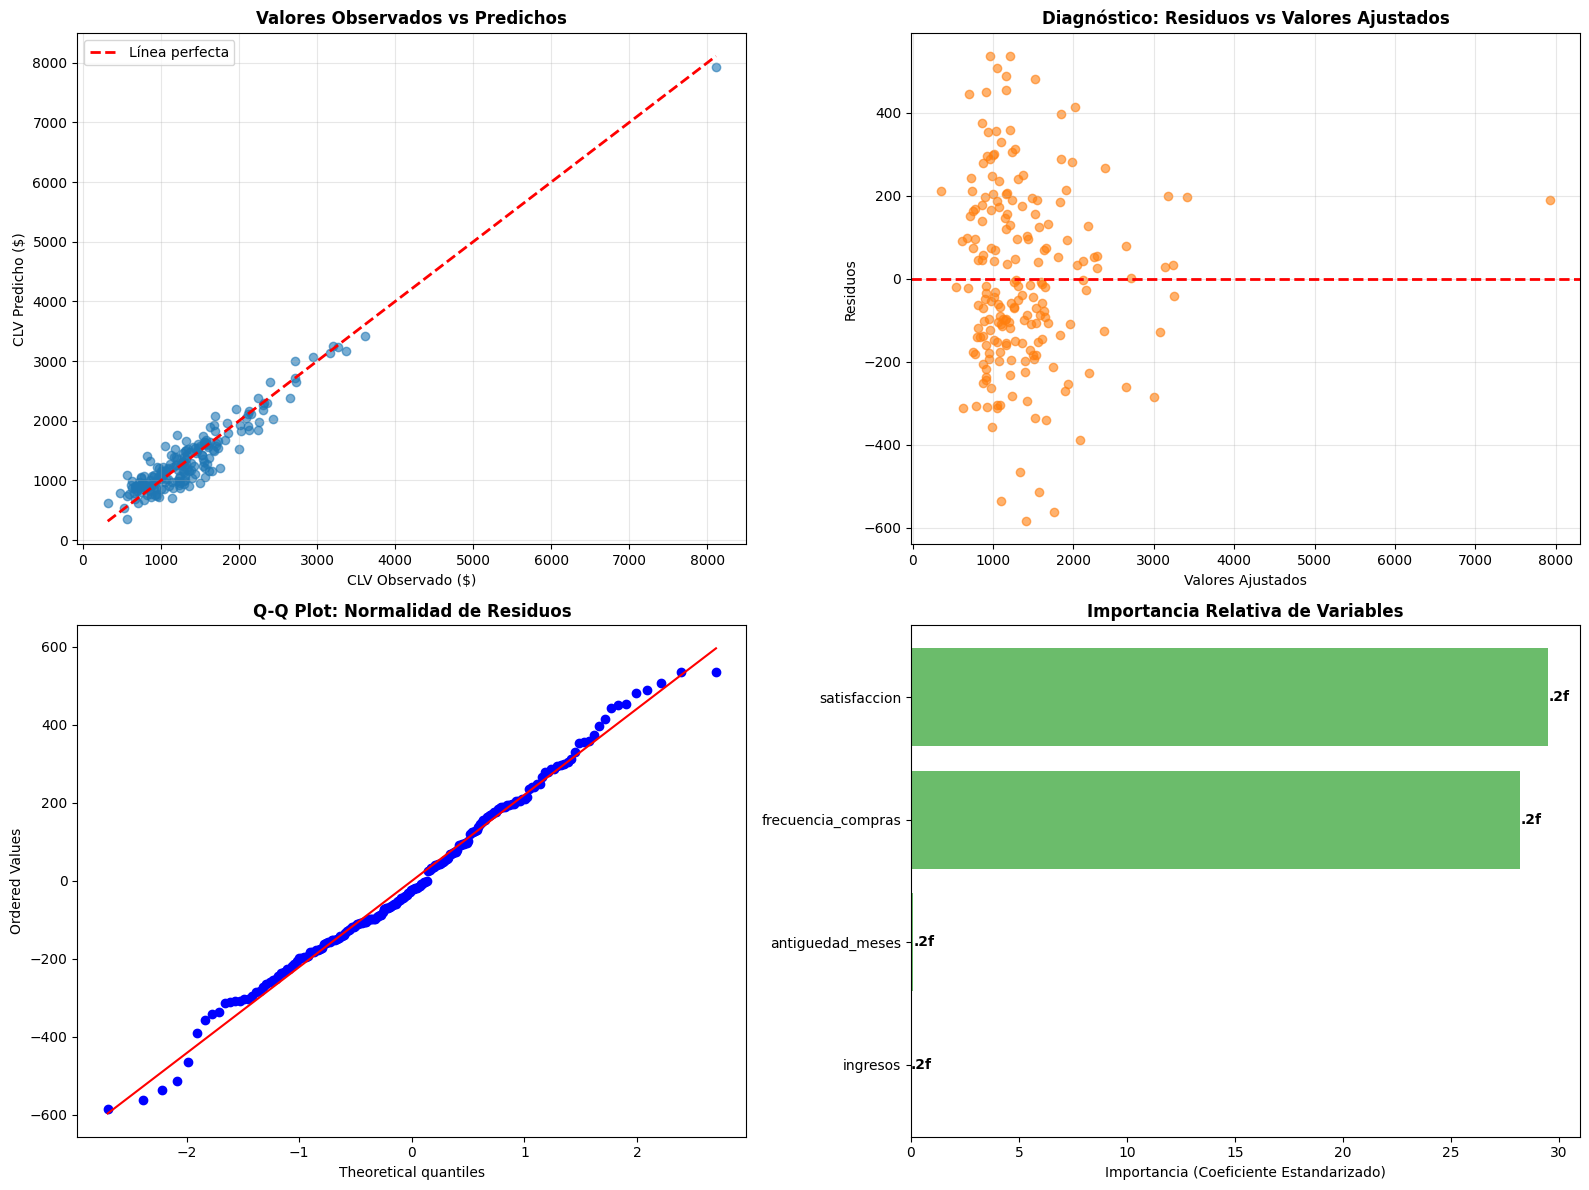

In [24]:
# Crear visualización comprehensiva del modelo
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Valores observados vs predichos
ax1.scatter(df['clv'], y_pred2, alpha=0.6, color='#1f77b4')
ax1.plot([df['clv'].min(), df['clv'].max()], [df['clv'].min(), df['clv'].max()], 
        'r--', linewidth=2, label='Línea perfecta')
ax1.set_xlabel('CLV Observado ($)')
ax1.set_ylabel('CLV Predicho ($)')
ax1.set_title('Valores Observados vs Predichos', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuos vs valores ajustados
ax2.scatter(valores_ajustados, residuos, alpha=0.6, color='#ff7f0e')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Valores Ajustados')
ax2.set_ylabel('Residuos')
ax2.set_title('Diagnóstico: Residuos vs Valores Ajustados', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Q-Q plot de residuos
stats.probplot(residuos, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot: Normalidad de Residuos', fontweight='bold')

# 4. Importancia de variables (coeficientes estandarizados)
coef_std = modelo2.params[1:] / df[['ingresos', 'frecuencia_compras', 'antiguedad_meses', 'satisfaccion']].std()
coef_std = coef_std.abs().sort_values(ascending=True)

bars = ax4.barh(range(len(coef_std)), coef_std.values, color='#2ca02c', alpha=0.7)
ax4.set_yticks(range(len(coef_std)))
ax4.set_yticklabels(coef_std.index)
ax4.set_xlabel('Importancia (Coeficiente Estandarizado)')
ax4.set_title('Importancia Relativa de Variables', fontweight='bold')

# Añadir valores en las barras
for i, (var, val) in enumerate(zip(coef_std.index, coef_std.values)):
    ax4.text(val + 0.01, i, '.2f', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('modelo_regresion_clv_completo.png', dpi=300, bbox_inches='tight')
print("\nAnálisis de modelo guardado como 'modelo_regresion_clv_completo.png'")

# Resumen ejecutivo
print("RESUMEN EJECUTIVO - MODELO CLV")
print("=" * 35)
print(f"R² del modelo: {r2_2:.1f} ({r2_2*100:.1f}% de variabilidad explicada)") 
print(f"RMSE: ${rmse_2:.0f} (error típico de predicción)") 
print(f"Variables significativas: {sum(p_values[1:] < 0.05)} de {len(p_values)-1}") 
print(f"Supuestos cumplidos: {sum([p_normalidad > 0.05, bp_test[1] > 0.05, abs(dw_stat - 2) < 0.5])} de 3")

#### Predicción para nuevo cliente

In [25]:
cliente_nuevo = pd.DataFrame({ 'ingresos': [80000], 'frecuencia_compras': [8], 'antiguedad_meses': [36], 'satisfaccion': [8.5] })

clv_predicho = modelo2.predict(cliente_nuevo)[0] 
print(f"\nPredicción para cliente nuevo: ${clv_predicho:.0f}")


Predicción para cliente nuevo: $2374
